In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix


import scanpy as sc
import scvi

import anndata
import os

scvi.settings.seed = 1

In [46]:
# counts_e12 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E12_5_gene_full_dense.tsv', index_col=0, sep='\t')
# counts_e12 = counts_e12[~counts_e12.index.duplicated(keep='first')]
# cells_e12 = ['e12_cell_' + str(i) for i in range(1, len(counts_e12.columns)+1)]
# counts_e12.columns = cells_e12

# counts_e13 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E13_5_gene_full_dense.tsv', index_col=0, sep='\t')
# counts_e13 = counts_e13[~counts_e13.index.duplicated(keep='first')]
# cells_e13 = ['e13_cell_' + str(i) for i in range(1, len(counts_e13.columns)+1)]
# counts_e13.columns = cells_e13

# shared = counts_e12.index & counts_e13.index
# merged_counts = pd.concat([counts_e12.loc[shared], counts_e13.loc[shared]], axis=1)
# del counts_e12
# del counts_e13

# counts_e14 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E14_5_gene_full_dense.tsv', index_col=0, sep='\t')
# counts_e14 = counts_e14[~counts_e14.index.duplicated(keep='first')]
# cells_e14 = ['e14_cell_' + str(i) for i in range(1, len(counts_e14.columns)+1)]
# counts_e14.columns = cells_e14

# shared = merged_counts.index & counts_e14.index
# merged_counts = pd.concat([merged_counts.loc[shared], counts_e14.loc[shared]], axis=1)
# del counts_e14

# counts_e15 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E15_5_gene_full_dense.tsv', index_col=0, sep='\t')
# counts_e15 = counts_e15[~counts_e15.index.duplicated(keep='first')]
# cells_e15 = ['e15_cell_' + str(i) for i in range(1, len(counts_e15.columns)+1)]
# counts_e15.columns = cells_e15

# shared = merged_counts.index & counts_e15.index
# merged_counts = pd.concat([merged_counts.loc[shared], counts_e15.loc[shared]], axis=1)
# del counts_e15

In [49]:
merged_counts.to_csv('~/psix_project/data/mouse_pancreas.tab.gz', sep='\t', index=True, header=True)

In [50]:
age = [x.split('_')[0] for x in merged_counts.columns]

(array([1537., 3294., 3305., 3109., 3400., 4538., 2788.,  901.,  176.,
          80.]),
 array([ 1.60943791,  2.98975517,  4.37007242,  5.75038968,  7.13070694,
         8.51102419,  9.89134145, 11.2716587 , 12.65197596, 14.03229321,
        15.41261047]),
 <a list of 10 Patch objects>)

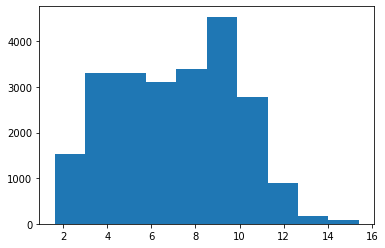

In [54]:
plt.hist(np.log1p(merged_counts.sum(axis=1)))

In [51]:
counts = merged_counts.T

adata = anndata.AnnData(counts)
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

adata.obs['age'] = age



sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

scvi.data.setup_anndata(adata, layer="counts")

sc.set_figure_params(figsize=(4, 4))


sc.pp.highly_variable_genes(
    adata,
    n_top_genes=10000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


scvi.data.setup_anndata(adata, layer="counts") # this might be needed
model = scvi.model.SCVI(adata)
model.train()
model.save("data/pancreas_model/")

model = scvi.model.SCVI.load("data/pancreas_model/", adata)



latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

sc.tl.pca(adata)


# adata.obs['cell_type'] = cell_type
# adata.obs['subtissue'] = subtissue
# adata.obs['sex'] = sex

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


MemoryError: Unable to allocate 3.21 GiB for an array with shape (37272, 23128) and data type float32

In [ ]:
# psix_object = psix.Psix()
# psix_object.process_rnaseq(
#         'data/preprocess/tables/SE_counts_filtered.tab.gz',
#         'data/preprocess/tables/constitutive_introns_filtered.tab.gz',
#         'data/preprocess/tables/rsem_gene_tpm_filtered.tab.gz',
#         minJR = 1,
#         minCell=1,
#         min_observed = 0.25)

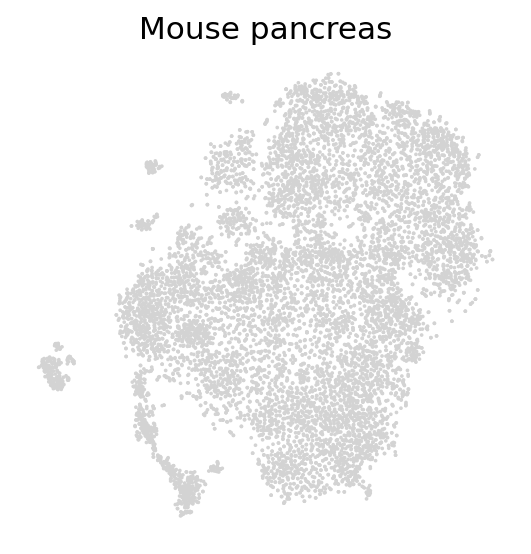

In [9]:
sc.tl.tsne(adata)
sc.pl.tsne(
    adata,
#     color="cell_type",
    title='Mouse pancreas',
    frameon=False,
)

In [29]:
scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 11)]

scvi_rd.to_csv('data/pancreas_E12_scvi_rd.tab.gz', sep='\t', index=True, header=True)

In [ ]:
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

# psix_object = psix.Psix(adata)
psix_object = psix.Psix()
psix_object.process_rnaseq(
        '~/psix_project/data/mouse_pancreas_SJ.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.01, tenX=True)



Obtaining psi tables...


In [ ]:
psix_object.compute_psix_scores(latent='data/mouse_pancreas_scvi_rd.tab.gz', n_jobs=25, n_random_exons=2000,
                               turbo = '~/psix_project/psix/psix/psix_turbo/')

In [7]:
psix_object.psix_results.to_csv('psix_results.tab.gz', sep='\t', index=True, header=True)

In [6]:
psix_object.compute_psix_scores(latent='data/pancreas_E12_scvi_rd.tab.gz', n_neighbors=300,
                                n_jobs=1, n_random_exons=500, turbo=False, 
                                turbo_dir = '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/psix_turbo/', 
                               pvals_bins=1)

  0%|          | 0/54 [00:00<?, ?it/s]

Computing Psix score in 54 exons


  0%|          | 0/500 [00:00<?, ?it/s]

Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 500/500 [09:04<00:00,  1.09s/it]


NameError: name 'buckets_scores' is not defined

In [8]:
psix_object.compute_psix_scores(latent='data/pancreas_E12_scvi_rd.tab.gz', n_neighbors=300,
                                n_jobs=10, n_random_exons=500, turbo=False, 
                                turbo_dir = '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/psix_turbo/', 
                               pvals_bins=1)

cell-cell metric not found. Computing metric...
Obtaining cell-cell neighbors and weights


 85%|████████▍ | 9237/10902 [10:51<01:57, 14.17it/s]


KeyboardInterrupt: 

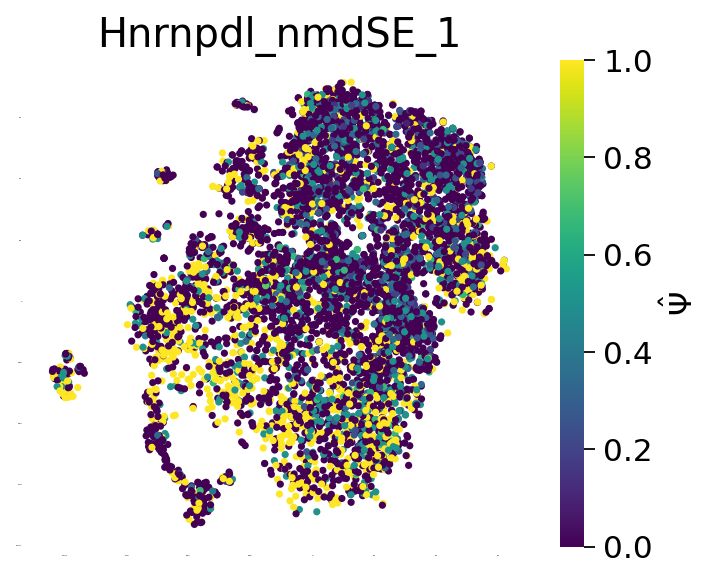

In [20]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.grid(False)
sc = ax.scatter(adata.obsm['X_tsne'].T[0], adata.obsm['X_tsne'].T[1], s=5,
               c = psix_object.adata.uns['psi']['Hnrnpdl_nmdSE_1'])
cb = plt.colorbar(sc)
cb.set_label(label='$\hat{\Psi}$',size=14)
cb.ax.tick_params(labelsize=14, length=5)
cb.outline.set_visible(False)
ax.set_title('Hnrnpdl_nmdSE_1', fontsize=18)
ax.set_xlabel('tSNE 1', fontsize=14)
ax.set_ylabel('tSNE 2', fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(labelsize=0, length=0)
plt.show()

In [8]:
psix_object.psix_results

,psix_score,pvals,qvals
Hnrnpdl_nmdSE_1,0.053576,0.001996,0.015569
Hnrnpa2b1_1,0.022144,0.001996,0.015569
Rnf130_2,0.000694,0.001996,0.015569
Bag6_7,-0.001563,0.001996,0.015569
Psmg4_1,-0.002094,0.001996,0.015569
Uqcr10_1,-0.007416,0.023952,0.116766
Vrk1_6,-0.007497,0.023952,0.116766
Snf8_3,-0.007599,0.023952,0.116766
Thyn1_1,-0.008907,0.083832,0.363273
Hnrnpab_2,-0.010145,0.165669,0.646108


In [14]:
np.isnan('hola')

In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

def load_turbo(turbo_dir = 'psix_turbo/'):
    turbo_files = os.listdir(turbo_dir)

    turbo_dict = {}
    for x in tqdm(turbo_files, position=0, leave=True):
        mrna_counts = int(x.split('.')[0].split('_')[-1])
        turbo_table = pd.read_csv(turbo_dir + x, sep='\t', index_col=0)
        turbo_table.index = [str(round(float(x), 2)) for x in turbo_table.index]
        turbo_table.columns = [str(round(float(x), 2)) for x in turbo_table.columns]
        turbo_dict.update({mrna_counts:turbo_table})
    return turbo_dict



def make_turbo(out_dir = 'psix_turbo/', granularity = 0.01, max_mrna = 20, capture_efficiency=0.1, min_probability=0.01):
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    observed_range = np.arange(0, 1+granularity, granularity)
    true_range = np.arange(granularity, 1, granularity)
    mrna_range = np.arange(1, max_mrna+1)
    
    for mrna in tqdm(mrna_range, leave=True, position=0):
        mrna_df = pd.DataFrame(np.ones((len(observed_range), len(true_range)))*min_probability, 
                               index=observed_range, columns=true_range)
        for observed_psi in observed_range:
            for true_psi in true_range:
                probability = probability_psi_observation(observed_psi, true_psi, capture_efficiency, mrna)
                mrna_df.loc[observed_psi, true_psi] = np.max((mrna_df.loc[observed_psi, true_psi], probability))

        mrna_df.to_csv(out_dir + 'psix_turbo_' + str(mrna)+'.tab.gz', sep='\t', index=True, header=True)

In [16]:
turbo_tables = load_turbo('/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/psix_turbo/')

100%|██████████| 20/20 [00:00<00:00, 61.14it/s]


Index(['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09',
       '0.1', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18',
       '0.19', '0.2', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27',
       '0.28', '0.29', '0.3', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36',
       '0.37', '0.38', '0.39', '0.4', '0.41', '0.42', '0.43', '0.44', '0.45',
       '0.46', '0.47', '0.48', '0.49', '0.5', '0.51', '0.52', '0.53', '0.54',
       '0.55', '0.56', '0.57', '0.58', '0.59', '0.6', '0.61', '0.62', '0.63',
       '0.64', '0.65', '0.66', '0.67', '0.68', '0.69', '0.7', '0.71', '0.72',
       '0.73', '0.74', '0.75', '0.76', '0.77', '0.78', '0.79', '0.8', '0.81',
       '0.82', '0.83', '0.84', '0.85', '0.86', '0.87', '0.88', '0.89', '0.9',
       '0.91', '0.92', '0.93', '0.94', '0.95', '0.96', '0.97', '0.98', '0.99'],
      dtype='object')

In [56]:
del merged_counts

In [1]:
import numpy as np
import pandas as pd
counts_e12 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E12_5_sj_full_dense.tsv', index_col=0, sep='\t')
counts_e12 = counts_e12[~counts_e12.index.duplicated(keep='first')]
cells_e12 = ['e12_cell_' + str(i) for i in range(1, len(counts_e12.columns)+1)]
counts_e12.columns = cells_e12

counts_e13 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E13_5_sj_full_dense.tsv', index_col=0, sep='\t')
counts_e13 = counts_e13[~counts_e13.index.duplicated(keep='first')]
cells_e13 = ['e13_cell_' + str(i) for i in range(1, len(counts_e13.columns)+1)]
counts_e13.columns = cells_e13

shared = counts_e12.index & counts_e13.index
merged_counts = pd.concat([counts_e12.loc[shared], counts_e13.loc[shared]], axis=1)
del counts_e12
del counts_e13

counts_e14 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E14_5_sj_full_dense.tsv', index_col=0, sep='\t')
counts_e14 = counts_e14[~counts_e14.index.duplicated(keep='first')]
cells_e14 = ['e14_cell_' + str(i) for i in range(1, len(counts_e14.columns)+1)]
counts_e14.columns = cells_e14

shared = merged_counts.index & counts_e14.index
merged_counts = pd.concat([merged_counts.loc[shared], counts_e14.loc[shared]], axis=1)
del counts_e14

counts_e15 = pd.read_csv('/mnt/lareaulab/carmelle/10x_pancreas/E15_5_sj_full_dense.tsv', index_col=0, sep='\t')
counts_e15 = counts_e15[~counts_e15.index.duplicated(keep='first')]
cells_e15 = ['e15_cell_' + str(i) for i in range(1, len(counts_e15.columns)+1)]
counts_e15.columns = cells_e15

shared = merged_counts.index & counts_e15.index
merged_counts = pd.concat([merged_counts.loc[shared], counts_e15.loc[shared]], axis=1)
del counts_e15

In [3]:
merged_counts.to_csv('~/psix_project/data/mouse_pancreas_SJ.tab.gz', sep='\t', index=True, header=True)